#### LSM(Log-Structured-Merge-Tree)
 [reference](https://blog.csdn.net/weixin_43778179/article/details/132622881)

LSM树并不像B+树、红黑树一样是一颗严格的树状数据结构，它其实是一种存储结构，目前HBase,LevelDB,RocksDB这些NoSQL存储都是采用的LSM树。

#### 核心思想

LSM树的核心特点是利用`顺序写`来提高写性能，但因为`分层(此处分层是指的分为内存和文件两部分)`的设计会稍微降低读性能，但是通过牺牲小部分读性能换来高性能写，使得LSM树成为非常流行的存储结构。

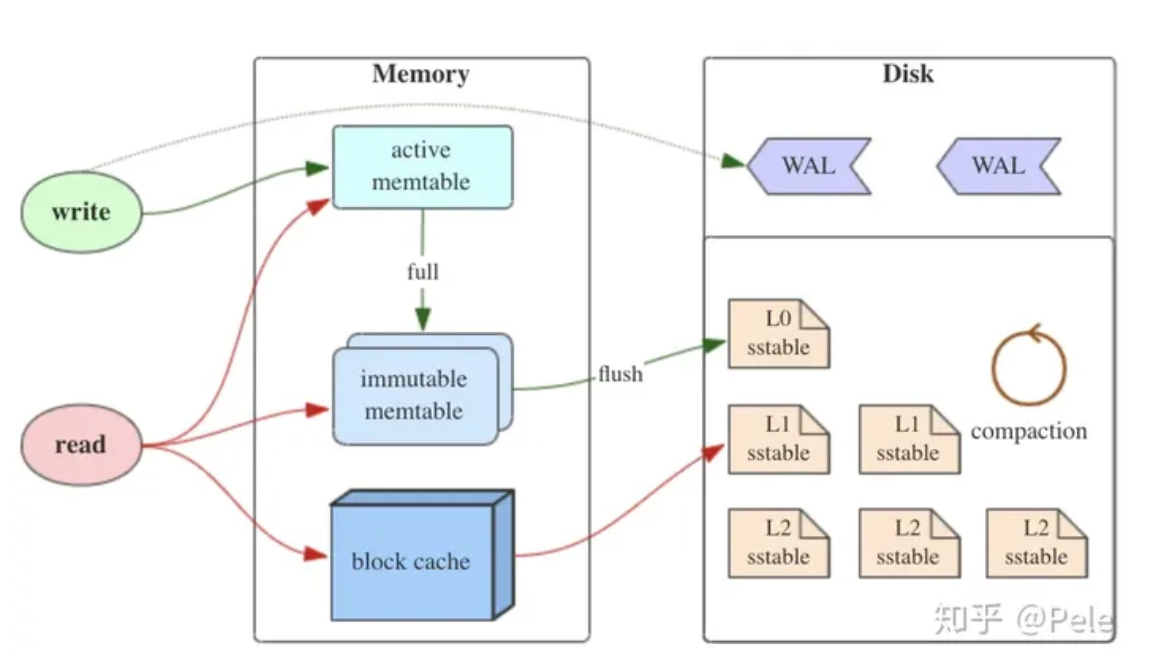

1. MemTable
   1. MemTable是在内存中的数据结构，用于保存最近更新的数据，会按照Key有序地组织这些数据，LSM树对于具体如何组织有序地组织数据并没有明确的数据结构定义，例如Hbase使跳跃表来保证内存中key的有序。
   2. 因为数据暂时保存在内存中，内存并不是可靠存储，如果断电会丢失数据，因此通常会通过WAL(Write-ahead logging，预写式日志)的方式来保证数据的可靠性。
2. Immutable MemTable
   1. 当 MemTable达到一定大小后，会转化成Immutable MemTable。Immutable MemTable是将转MemTable变为SSTable的一种中间状态。写操作由新的MemTable处理，在转存过程中不阻塞数据更新操作。
3. SSTable(Sorted String Table)
   1. 有序键值对集合，是LSM树组在磁盘中的数据结构。为了加快SSTable的读取，可以通过建立key的索引以及布隆过滤器来加快key的查找。
   2. 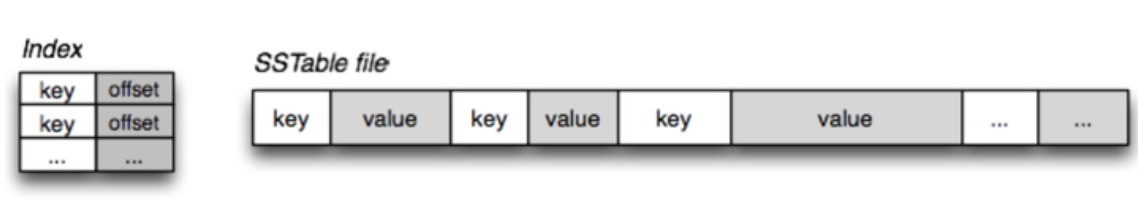

这里需要关注一个重点，LSM树(Log-Structured-Merge-Tree)正如它的名字一样，LSM树会将所有的数据插入、修改、删除等操作记录(注意是操作记录)保存在内存之中，当此类操作达到一定的数据量后，再批量地顺序写入到磁盘当中。这与B+树不同，B+树数据的更新会直接在原数据所在处修改对应的值，但是LSM数的数据更新是日志式的，当一条数据更新是直接append一条更新记录完成的。这样设计的目的就是为了顺序写，不断地将Immutable MemTable flush到持久化存储即可，而不用去修改之前的SSTable中的key，保证了顺序写。

因此当MemTable达到一定大小flush到持久化存储变成SSTable后，在不同的SSTable中，可能存在相同Key的记录，当然最新的那条记录才是准确的。这样设计的虽然大大提高了写性能，但同时也会带来一些问题：
1. 冗余存储，对于某个key，实际上除了最新的那条记录外，其他的记录都是冗余无用的，但是仍然占用了存储空间。因此需要进行Compact操作(合并多个SSTable)来清除冗余的记录。
2. 读取时需要从最新的倒着查询，直到找到某个key的记录。最坏情况需要查询完所有的SSTable，这里可以通过前面提到的索引/布隆过滤器来优化查找速度。
